# NLP Methods on Music Reviews: Cleaning and EDA
This notebook covers ingesting and preprocessing the text of music reviews, retrieved from the Kaggle dataset [song reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data)

In [119]:
import pandas as pd
import numpy as np
import sqlite3
import string, re
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khyate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/khyate/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/khyate/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/khyate/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Import Data
The data is stored as a series of tables within a sqlite database. The following cells extract each table and convert them to Pandas dataframes.

### Connect to the Database

In [3]:
connection = sqlite3.connect('datasets/database.sqlite')
cursor = connection.cursor()

### Reviews Table

In [21]:
query = "select * from reviews;"
cursor.execute(query)
df_reviews = pd.DataFrame(cursor.fetchall(), columns=["id",'track', 'artist', 'url','score',
    'best_new_music', 'author', 'author_type','date','weekday', 'day', 'month', 'year'])
df_reviews.head()

,id,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [22]:
len(df_reviews)

18393

### Content Table

In [23]:
query = "select * from content;"
cursor.execute(query)
df_content = pd.DataFrame(cursor.fetchall(), columns=["id",'review'])
df_content.head()

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


### Genres Table

In [144]:
query = "select * from genres;"
cursor.execute(query)
df_genres = pd.DataFrame(cursor.fetchall(), columns=["id",'genre'])
df_genres.head()
df_genres['genre'].value_counts()

rock            9436
electronic      3874
experimental    1815
rap             1559
pop/r&b         1432
metal            860
folk/country     685
jazz             435
global           217
Name: genre, dtype: int64

## Merge Dataframes

In [145]:
df = df_content.merge(df_reviews, on='id')
df.drop_duplicates(inplace=True)
df.head(5)

,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,"Eight years, five albums, and two EPs in, the ...",prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,Kleenex began with a crash. It transpired one ...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,It is impossible to consider a given release b...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [44]:
len(df)

18389

In [47]:
# df.to_parquet("../datasets/reviews.parquet")

# EDA
We perform light exploratory data analysis to understand the contents of the dataset

In [116]:
# descriptive statistics of score column

df.score.describe()

count    18389.000000
mean         7.005715
std          1.293758
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64

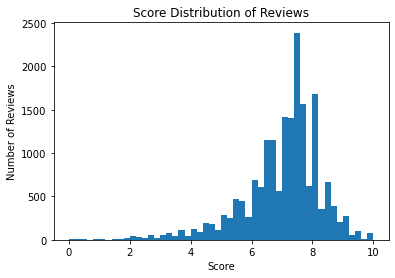

In [165]:
# distribution of scores

plt.hist(df.score, bins=50)
plt.title("Score Distribution of Reviews")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.savefig("images/Score Distribution of Reviews.png")

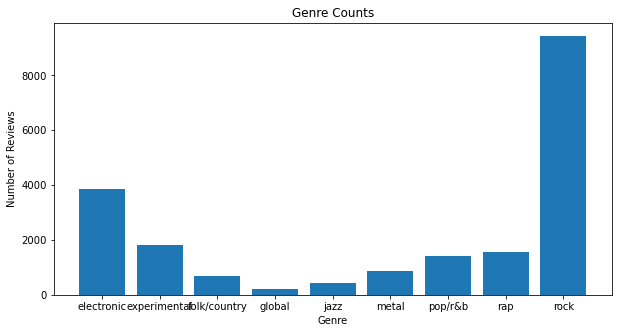

In [147]:
# Genre counts

plt.figure(figsize=(10, 5));
plt.bar(df_genres.groupby('genre').count().id.index, df_genres.groupby('genre').count().id.values)
plt.title("Genre Counts")
plt.xlabel("Genre")
plt.ylabel("Number of Reviews")
plt.savefig("images/Genre Counts.png")

In [149]:
# Average length of reviews

review_lengths = df.review.apply(lambda x: len(x.split(' ')))
print("Average length of reviews:",review_lengths.mean())
print("Number of words from all reviews:",review_lengths.sum())

Average length of reviews: 703.0016857904182
Number of words from all reviews: 12927498


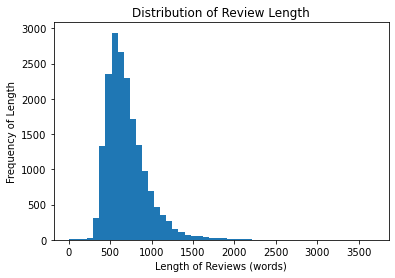

In [162]:
plt.hist(review_lengths, bins=50)
plt.title("Distribution of Review Length")
plt.xlabel("Length of Reviews (words)")
plt.ylabel("Frequency of Length")
plt.savefig("images/Distribution of Review Length.png")

# Data Pre-processing
The following cells perform text preprocessing steps


In [151]:
def tokenize(texts):
    """Tokenize and convert to lower case"""
    tokenized = []
    for text in texts:
        tokenized.append(nltk.word_tokenize(text.lower()))
    return(tokenized)

In [152]:
def stop_words(tokenized_texts):
    """Remove stopwords and punctuation from each review"""
    stopped = []
    eng_stopwords = stopwords.words('english')
    eng_stopwords += list(string.punctuation)
    eng_stopwords += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘']
    for token_list in tokenized_texts:
        stopwords_removed = [token for token in token_list if token not in eng_stopwords]
        stopped.append(stopwords_removed)

    return stopped

In [153]:
def lemmatize(tokenized_texts):
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for token_list in tokenized_texts:
        lemmatized.append([lemmatizer.lemmatize(token) for token in token_list])
    return lemmatized

### Implement Tokenization, Stop Word Removal, and Lemmatization

In [154]:
tokenized = tokenize(df.review)
no_stop = stop_words(tokenized)
lemmed = lemmatize(no_stop)
len(lemmed)

18389

In [155]:
# join tokens back together to save as parquet file
processed = []
for token_list in lemmed:
    processed.append(' '.join(token_list))
len(processed)

18389

In [156]:
df["preprocessed_review"] = processed
# df.to_parquet("../datasets/processed_reviews.parquet")
df.head()


,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year,preprocessed_review
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,trip-hop eventually became 90 punchline music-...
1,22721,"Eight years, five albums, and two EPs in, the ...",prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,eight year five album two eps new york-based o...
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,minneapolis uranium club seem revel aggressive...
3,22661,Kleenex began with a crash. It transpired one ...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,kleenex began crash transpired one night long ...
4,22725,It is impossible to consider a given release b...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,impossible consider given release footwork art...


### Inspect first 100 characters of sample review, comparing raw review vs pre-processed

In [157]:
# Preprocessed
df.preprocessed_review[0][:100]

'trip-hop eventually became 90 punchline music-press shorthand overhyped hotel lounge music. today mu'

In [158]:
# Original
df.review[0][:100]

'“Trip-hop” eventually became a ’90s punchline, a music-press shorthand for “overhyped hotel lounge m'

In [159]:
preprocessed_review_lengths = df.preprocessed_review.apply(lambda x: len(x.split(' ')))
print("Average token length of reviews:",preprocessed_review_lengths.mean())
print("Number of tokens from all reviews:",preprocessed_review_lengths.sum())

Average token length of reviews: 394.3906683343303
Number of tokens from all reviews: 7252450


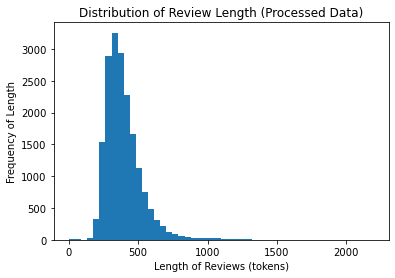

In [164]:
plt.hist(preprocessed_review_lengths, bins=50)
plt.title("Distribution of Review Length (Processed Data)")
plt.xlabel("Length of Reviews (tokens)")
plt.ylabel("Frequency of Length")
plt.savefig("images/Distribution of Review Length(tokens).png")